
### ***Simple approach:*** 

### step 2 - classification (segformer)

### input: npz file with tensors post-disaster (images and binary masks)  created with "get_tensors_pre_post"


In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## loading tensors post disaster

In [3]:
# NPZ FILE was created with get_tensors_pre_post nb using post-disaster images in png format and json files containing building damage level (json "post" files)
# Additionally, tensors contained in npz file contain information about the disaster

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_post = np.load('../data/tensors_post_xBD_last_subset.npz')




In [4]:
# getting images and masks from post tensors

images_post = loaded_arrays_post['images']
masks_post = loaded_arrays_post['masks']
id_post = loaded_arrays_post['id'] # file names for each image-mask pair


In [5]:
# example of first id
id_post[0]

'hurricane-harvey_00000289_post_disaster'

In [39]:
#features (images) and target (mask)

# UNCOMMENT HERE TO USE ALL DATA
#X = images_post
#y = masks_post
# TAKING A SMALL SUBSET OF THE DATA TO TEST
X = images_post[0:50]
y = masks_post[0:50]

#checking shape
print("lenght X and y: ",len(X), len(y)) 
print ("image dimensions: ",X[0].shape)
print ("mask dimensions: ",y[0].shape)


lenght X and y:  50 50
image dimensions:  (1024, 1024, 3)
mask dimensions:  (1024, 1024, 1)


In [40]:
# SPLITTING
# split data into 80/20 ratio

train_X, val_X,train_y, val_y= train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )

In [41]:

# develop tf Dataset objects

train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X,val_y))



In [42]:
# verify the shapes and data types
print("type datasets: ",train_dataset.element_spec, val_dataset.element_spec)
print("lenght train: ",len(train_dataset))
print("lenght test: ",len(val_dataset))

type datasets:  (TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1024, 1024, 1), dtype=tf.uint8, name=None)) (TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1024, 1024, 1), dtype=tf.uint8, name=None))
lenght train:  40
lenght test:  10


In [43]:
# Augmentation functions

# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask
# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [44]:
# perform augmentation on train data only
# uncomment desired augmentation in both following blocks if needed

#a = train_dataset.map(brightness)
#b = train_dataset.map(gamma)
#c = train_dataset.map(hue)
#d = train_dataset.map(crop)
#e = train_dataset.map(flip_hori)
#f = train_dataset.map(flip_vert)
#g = train_dataset.map(rotate)

# concatenate every new augmented sets
#train_dataset = train_dataset.concatenate(a)
#train_dataset = train_dataset.concatenate(b)
#train_dataset = train_dataset.concatenate(c)
#train_dataset = train_dataset.concatenate(d)
#train_dataset = train_dataset.concatenate(e)
#train_dataset = train_dataset.concatenate(f)
#train_dataset = train_dataset.concatenate(g)


In [45]:
sample = next(iter(train_dataset))
image, mask = sample[0], sample[1]

# Inspect the shape and data type of the image and mask
print("Image shape:", image.shape)  # E.g., (height, width, channels)
print("Image data type:", image.dtype)  # E.g., float32

print("Mask shape:", mask.shape)  # E.g., (height, width, 1)
print("Mask data type:", mask.dtype)  # E.g., int64

print("Length train and val: ",len(train_dataset),len(val_dataset))

Image shape: (1024, 1024, 3)
Image data type: <dtype: 'uint8'>
Mask shape: (1024, 1024, 1)
Mask data type: <dtype: 'uint8'>
Length train and val:  40 10


In [46]:
# function to prepare dataset as correct input for model

def map_fn(image, mask):
    """set names on tensorflow dataset
    
    Args:
        image (~EagerTensor): image tensor
        mask (~EagerTensor): mask tensor
    Returns:
         tensorflow dataset (~TensorSpec) with names
    """
    # Assign names to the elements in the dataset
    return {"image": image, "segmentation_mask": mask}

#applying function to train and val datasets

named_dataset_train = train_dataset.map(map_fn)
named_dataset_val = val_dataset.map(map_fn)



In [47]:
# important functions for pre-processing

# here we tried with nearest instead bilinear method
# to solve the problem of getting pixels with categories
# that do not exist after resizing

from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    """normalize input tensors
    
    Args:
        image (~EagerTensor): image tensor
        mask (~EagerTensor): mask tensor
    Returns:
        normalized image and mask tensors
    """
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    """Resize and normalize images and masks. Transpose channels of images.
    
    Args:
        datapoint (~EagerTensor): tuple of tensors (image and mask). Element of tensorflow dataset 
    
    Returns:
         tensorflow dataset (~TensorSpec) with correct format for segformer
    """
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        #method="bilinear",
        method="nearest",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}    

In [48]:
# create train and val datasets with right segformer input format

auto = tf.data.AUTOTUNE
# adjust batch_size 
# according machine capabilities
batch_size = 4

train = (
    named_dataset_train
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val = (
    named_dataset_val
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

## MODEL

In [49]:
# load the model (https://keras.io/examples/vision/segformer/)

from transformers import TFSegformerForSemanticSegmentation

# advanced version of segformer is mit-b5, change if power allows it
model_checkpoint = "nvidia/mit-b0"
#In this problem, labels in case of classification are 5
id2label = {0: "background", 1: "no-damage", 2: "minor-damage", 3: "major-damage", 4: "destroyed"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# more parameters
# learning rate

lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# compiling the model with the optimizer
model.compile(optimizer=optimizer)

In [51]:
# let's have a look to the pre-trained model layers
model.summary()

Model: "tf_segformer_for_semantic_segmentation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  396549    
 codeHead)                                                       
                                                                 
Total params: 3715941 (14.18 MB)
Trainable params: 3715429 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [52]:
# Important functions in the case you want to visualize the performance of the model
import matplotlib.pyplot as plt

#the following function has not been implemented to display while the model runs
def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width,_ = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building) or un-classified
        1:(255, 255, 255),  # Class 1 - White (no-damage)
        2:(255,255,0),     # Class 2 - Yellow (minor damage)
        3:(255,165,0),     # Class 3 - Orange (major damage)
        4:(255, 0, 0),     # Class 4 - Red (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x,0]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

def display(display_list):
    """displays tensors in "display_list" variable
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()




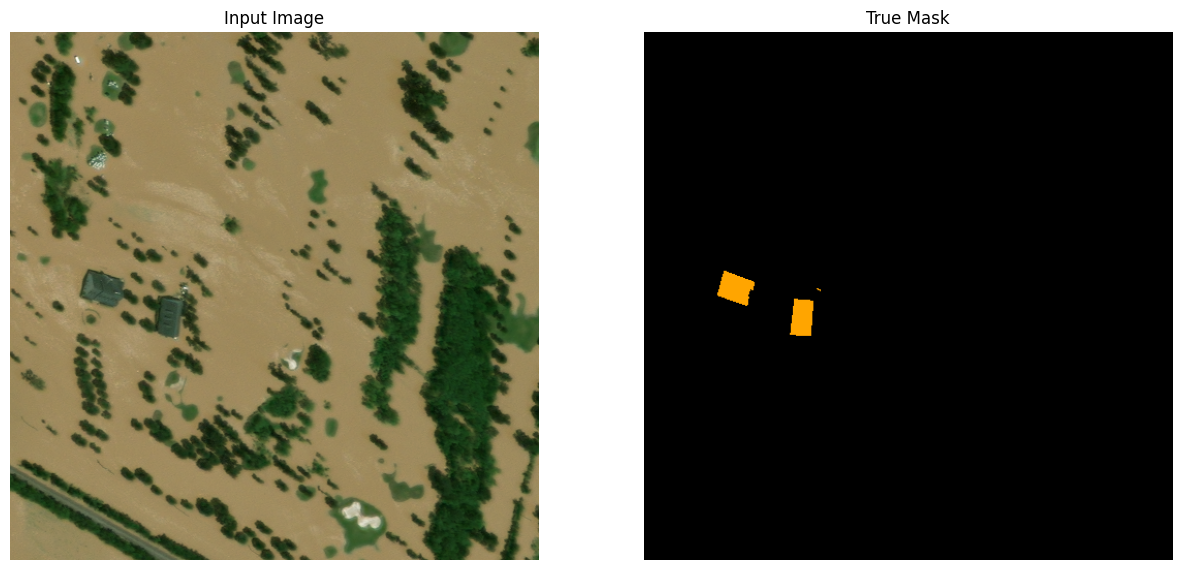

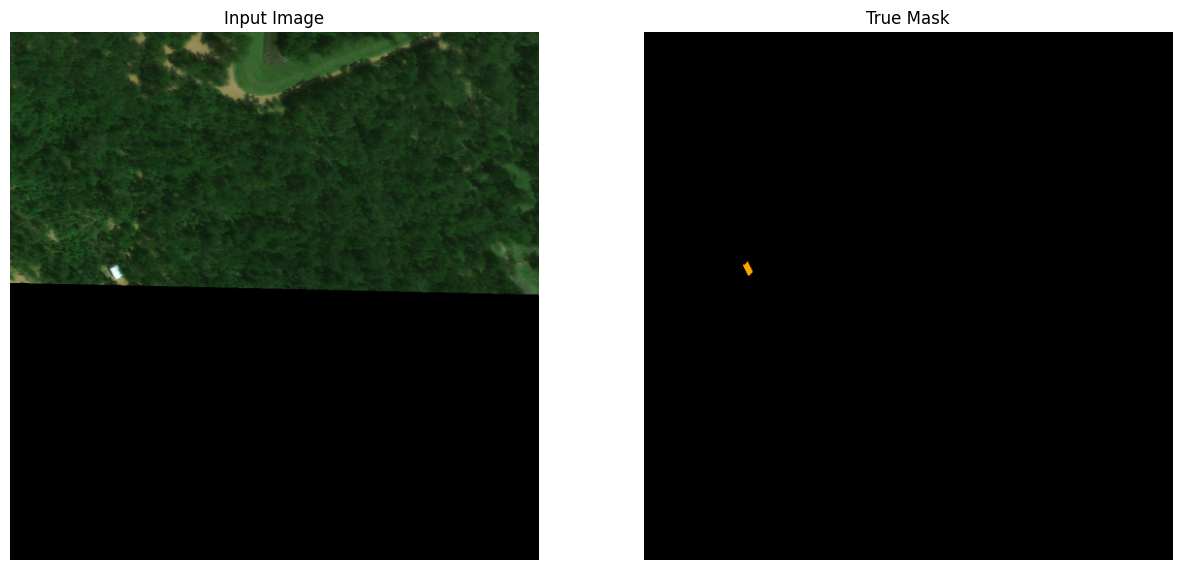

In [53]:
# example on how display function works (using only the first 2 image-mask pairs)

for samples in val.take(2):
    
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    sample_mask_deep = convert_mask_to_3_channels(np.array(sample_mask))

    display([sample_image, sample_mask_deep])

In [54]:
# more important functions to be able to evaluate visually the model performance
# from https://keras.io/examples/vision/segformer/

from IPython.display import clear_output


def create_mask(pred_mask):
    """Create a mask with a format to be input in display function.
    
    Args:
        pred_mask (~tensor): A mask array output of model.predict().logits.
        
    Returns:
        mask (~tensor) to plot.
    """
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]



def show_predictions(dataset=None, num=1):
    """shows image, ground truth mask and predicted mask from a given dataset.
       dataset includes batch dimension and num=1 sets only the first triplet of the batch. 
    
    Args:
        dataset (~tensorflow dataset): dataset with tuples image-mask
        num (~int): how many elements of dataset batch will be shown
    Returns:
        mask (~tensor) to plot.
    """
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )

# defining visualization callback
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

# Train the Model

1/1 [==============================] - 2s 2s/step


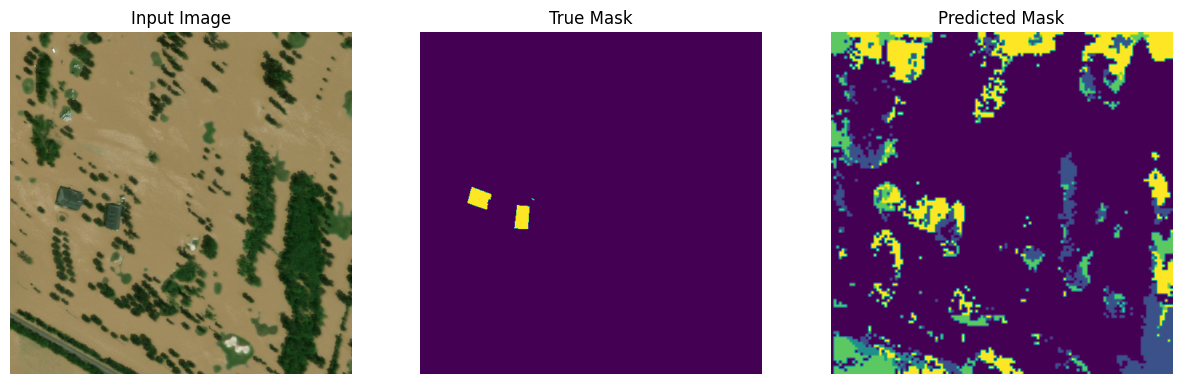


Sample Prediction after epoch 2

10/10 [==============================] - 60s 6s/step - loss: 1.3140 - val_loss: 1.2098


In [55]:
# RUNNING THE MODEL

# adjust the number of epochs (10 maximum in a laptop)
n_epochs=2

# fit model and add important callbacks
history = model.fit(
    train,
    validation_data=val,
    callbacks=[DisplayCallback(val)],
    epochs=n_epochs,
)


The results shown above are based on a remarkably small dataset (consisting of 40 training and 10 validation images). Performance shows a significant improvement when applied to a larger dataset, even with a total of 10 epochs.

In [56]:
# give the name of a folder where to save the model
model_checkpoint_dir = "classification_model_test1"

#create directory
try:
    os.makedirs(model_checkpoint_dir)
except FileExistsError:
    print(f"Directory '{model_checkpoint_dir}' already exists.")    
    
# Save the model after training
model.save_pretrained(model_checkpoint_dir)    



Directory 'classification_model_test1' already exists.


In [57]:
# path to where the history will be saved
history_file_path = os.path.join(model_checkpoint_dir, "history.json")

# save history in json file

import json

with open(history_file_path, 'w') as history_file:
    json.dump(history.history, history_file)


In [58]:
# TO LOAD THE HISTORY


# Load the training history from the JSON file
with open(history_file_path, "r") as history_file:
    history = json.load(history_file)

# Now you can access the loss and other metrics from the history dictionary
loss = history["loss"]
val_loss = history["val_loss"]
epoch = [x for x in range(1,n_epochs+1)]

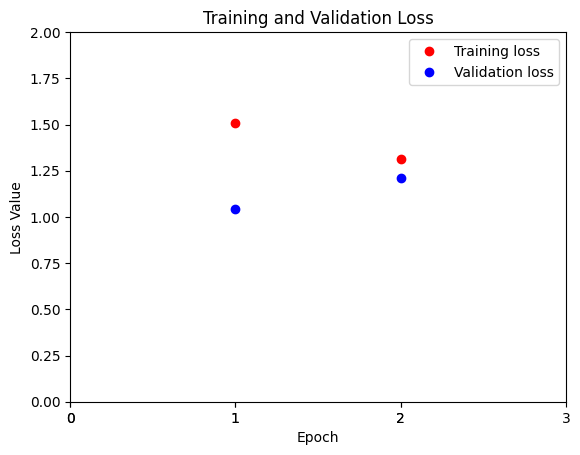

In [59]:
# plot the training and validation loss

plt.figure()
plt.plot(epoch, loss, 'ro', label='Training loss')
plt.plot(epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.xlim([0, n_epochs+1])
# converting epochs axis in integer values
xint=[]
locs, labels = plt.xticks()
for each in locs:
    xint.append(int(each))
plt.xticks(xint)


plt.legend()
plt.show()